In [1]:
! wget http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip

--2019-09-07 05:00:56--  http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip [following]
--2019-09-07 05:00:56--  https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6372817 (6.1M) [application/zip]
Saving to: ‘stanfordSentimentTreebank.zip’

stanfordSentimentTr 100%[===================>]   6.08M  1.90MB/s    in 3.2s    

2019-09-07 05:01:00 (1.90 MB/s) - ‘stanfordSentimentTreebank.zip’ saved [6372817/6372817]



In [2]:
! unzip stanfordSentimentTreebank.zip

Archive:  stanfordSentimentTreebank.zip
   creating: stanfordSentimentTreebank/
  inflating: stanfordSentimentTreebank/datasetSentences.txt  
   creating: __MACOSX/
   creating: __MACOSX/stanfordSentimentTreebank/
  inflating: __MACOSX/stanfordSentimentTreebank/._datasetSentences.txt  
  inflating: stanfordSentimentTreebank/datasetSplit.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._datasetSplit.txt  
  inflating: stanfordSentimentTreebank/dictionary.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._dictionary.txt  
  inflating: stanfordSentimentTreebank/original_rt_snippets.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._original_rt_snippets.txt  
  inflating: stanfordSentimentTreebank/README.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._README.txt  
  inflating: stanfordSentimentTreebank/sentiment_labels.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._sentiment_labels.txt  
  inflating: stanfordSentimentTreebank/SOStr.txt  
  inflating: stanfo

In [0]:
! rm stanfordSentimentTreebank.zip

In [0]:
import os, pickle, glob, random, time
import os.path as op

import cupy as np
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 0
%matplotlib inline

In [0]:
class StanfordSentiment:
    def __init__(self, path=None, tablesize = 1000000):
        if not path:
            path = "./stanfordSentimentTreebank"

        self.path = path
        self.tablesize = tablesize

    def tokens(self):
        if hasattr(self, "_tokens") and self._tokens:
            return self._tokens

        tokens = dict()
        tokenfreq = dict()
        wordcount = 0
        revtokens = []
        idx = 0

        for sentence in self.sentences():
            for w in sentence:
                wordcount += 1
                if not w in tokens:
                    tokens[w] = idx
                    revtokens += [w]
                    tokenfreq[w] = 1
                    idx += 1
                else:
                    tokenfreq[w] += 1

        tokens["UNK"] = idx
        revtokens += ["UNK"]
        tokenfreq["UNK"] = 1
        wordcount += 1

        self._tokens = tokens
        self._tokenfreq = tokenfreq
        self._wordcount = wordcount
        self._revtokens = revtokens
        return self._tokens

    def sentences(self):
        if hasattr(self, "_sentences") and self._sentences:
            return self._sentences

        sentences = []
        with open(self.path + "/datasetSentences.txt", "r") as f:
            first = True
            for line in f:
                if first:
                    first = False
                    continue

                splitted = line.strip().split()[1:]
                # Deal with some peculiar encoding issues with this file
                sentences += [[w.lower() for w in splitted]]

        self._sentences = sentences
        self._sentlengths = np.array([len(s) for s in sentences])
        self._cumsentlen = np.cumsum(self._sentlengths)

        return self._sentences

    def numSentences(self):
        if hasattr(self, "_numSentences") and self._numSentences:
            return self._numSentences
        else:
            self._numSentences = len(self.sentences())
            return self._numSentences

    def allSentences(self):
        if hasattr(self, "_allsentences") and self._allsentences:
            return self._allsentences

        sentences = self.sentences()
        rejectProb = self.rejectProb()
        tokens = self.tokens()
        allsentences = [[w for w in s
            if 0 >= rejectProb[tokens[w]] or random.random() >= rejectProb[tokens[w]]]
            for s in sentences * 30]

        allsentences = [s for s in allsentences if len(s) > 1]

        self._allsentences = allsentences

        return self._allsentences

    def getRandomContext(self, C=5):
        allsent = self.allSentences()
        sentID = random.randint(0, len(allsent) - 1)
        sent = allsent[sentID]
        wordID = random.randint(0, len(sent) - 1)

        context = sent[max(0, wordID - C):wordID]
        if wordID+1 < len(sent):
            context += sent[wordID+1:min(len(sent), wordID + C + 1)]

        centerword = sent[wordID]
        context = [w for w in context if w != centerword]

        if len(context) > 0:
            return centerword, context
        else:
            return self.getRandomContext(C)

    def sent_labels(self):
        if hasattr(self, "_sent_labels") and self._sent_labels:
            return self._sent_labels

        dictionary = dict()
        phrases = 0
        with open(self.path + "/dictionary.txt", "r") as f:
            for line in f:
                line = line.strip()
                if not line: continue
                splitted = line.split("|")
                dictionary[splitted[0].lower()] = int(splitted[1])
                phrases += 1

        labels = [0.0] * phrases
        with open(self.path + "/sentiment_labels.txt", "r") as f:
            first = True
            for line in f:
                if first:
                    first = False
                    continue

                line = line.strip()
                if not line: continue
                splitted = line.split("|")
                labels[int(splitted[0])] = float(splitted[1])

        sent_labels = [0.0] * self.numSentences()
        sentences = self.sentences()
        for i in range(self.numSentences()):
            sentence = sentences[i]
            full_sent = " ".join(sentence).replace('-lrb-', '(').replace('-rrb-', ')')
            sent_labels[i] = labels[dictionary[full_sent]]

        self._sent_labels = sent_labels
        return self._sent_labels

    def dataset_split(self):
        if hasattr(self, "_split") and self._split:
            return self._split

        split = [[] for i in range(3)]
        with open(self.path + "/datasetSplit.txt", "r") as f:
            first = True
            for line in f:
                if first:
                    first = False
                    continue

                splitted = line.strip().split(",")
                split[int(splitted[1]) - 1] += [int(splitted[0]) - 1]

        self._split = split
        return self._split

    def getRandomTrainSentence(self):
        split = self.dataset_split()
        sentId = split[0][random.randint(0, len(split[0]) - 1)]
        return self.sentences()[sentId], self.categorify(self.sent_labels()[sentId])

    def categorify(self, label):
        if label <= 0.2:
            return 0
        elif label <= 0.4:
            return 1
        elif label <= 0.6:
            return 2
        elif label <= 0.8:
            return 3
        else:
            return 4

    def getDevSentences(self):
        return self.getSplitSentences(2)

    def getTestSentences(self):
        return self.getSplitSentences(1)

    def getTrainSentences(self):
        return self.getSplitSentences(0)

    def getSplitSentences(self, split=0):
        ds_split = self.dataset_split()
        return [(self.sentences()[i], self.categorify(self.sent_labels()[i])) for i in ds_split[split]]

    def sampleTable(self):
        if hasattr(self, '_sampleTable') and self._sampleTable is not None:
            return self._sampleTable

        nTokens = len(self.tokens())
        samplingFreq = np.zeros((nTokens,))
        self.allSentences()
        i = 0
        for w in range(nTokens):
            w = self._revtokens[i]
            if w in self._tokenfreq:
                freq = 1.0 * self._tokenfreq[w]
                # Reweigh
                freq = freq ** 0.75
            else:
                freq = 0.0
            samplingFreq[i] = freq
            i += 1

        samplingFreq /= np.sum(samplingFreq)
        samplingFreq = np.cumsum(samplingFreq) * self.tablesize

        self._sampleTable = [0] * self.tablesize

        j = 0
        for i in range(self.tablesize):
            while i > samplingFreq[j]:
                j += 1
            self._sampleTable[i] = j

        return self._sampleTable

    def rejectProb(self):
        if hasattr(self, '_rejectProb') and self._rejectProb is not None:
            return self._rejectProb

        threshold = 1e-5 * self._wordcount

        nTokens = len(self.tokens())
        rejectProb = np.zeros((nTokens,))
        for i in range(nTokens):
            w = self._revtokens[i]
            freq = 1.0 * self._tokenfreq[w]
            # Reweigh
            rejectProb[i] = max(0, 1 - np.sqrt(threshold / freq))

        self._rejectProb = rejectProb
        return self._rejectProb

    def sampleTokenIdx(self):
        return self.sampleTable()[random.randint(0, self.tablesize - 1)]

In [0]:
def normalizeRows(x):
    """ Row normalization function

    Implement a function that normalizes each row of a matrix to have
    unit length.
    """
    N = x.shape[0]
    x /= np.sqrt(np.sum(x**2, axis=1)).reshape((N,1)) + 1e-30
    return x

def softmax(x):
    """Compute the softmax function for each row of the input x.
    It is crucial that this function is optimized for speed because
    it will be used frequently in later code. 

    Arguments:
    x -- A D dimensional vector or N x D dimensional numpy matrix.
    Return:
    x -- You are allowed to modify x in-place
    """
    orig_shape = x.shape

    if len(x.shape) > 1:
        # Matrix
        tmp = np.max(x, axis=1)
        x -= tmp.reshape((x.shape[0], 1))
        x = np.exp(x)
        tmp = np.sum(x, axis=1)
        x /= tmp.reshape((x.shape[0], 1))
    else:
        # Vector
        tmp = np.max(x)
        x -= tmp
        x = np.exp(x)
        tmp = np.sum(x)
        x /= tmp

    assert x.shape == orig_shape
    return x

In [0]:
SAVE_PARAMS_EVERY = 5000

def load_saved_params():
    """
    A helper function that loads previously saved parameters and resets
    iteration start.
    """
    st = 0
    for f in glob.glob("saved_params_*.npy"):
        iter = int(op.splitext(op.basename(f))[0].split("_")[2])
        if (iter > st):
            st = iter

    if st > 0:
        params_file = "saved_params_%d.npy" % st
        state_file = "saved_state_%d.pickle" % st
        params = np.load(params_file)
        with open(state_file, "rb") as f:
            state = pickle.load(f)
        return st, params, state
    else:
        return st, None, None


def save_params(iter, params):
    params_file = "saved_params_%d.npy" % iter
    np.save(params_file, params)
    with open("saved_state_%d.pickle" % iter, "wb") as f:
        pickle.dump(random.getstate(), f)


def sgd(f, x0, step, iterations, postprocessing=None, useSaved=False,
        PRINT_EVERY=10):
    """ Stochastic Gradient Descent

    Implement the stochastic gradient descent method in this function.

    Arguments:
    f -- the function to optimize, it should take a single
         argument and yield two outputs, a loss and the gradient
         with respect to the arguments
    x0 -- the initial point to start SGD from
    step -- the step size for SGD
    iterations -- total iterations to run SGD for
    postprocessing -- postprocessing function for the parameters
                      if necessary. In the case of word2vec we will need to
                      normalize the word vectors to have unit length.
    PRINT_EVERY -- specifies how many iterations to output loss

    Return:
    x -- the parameter value after SGD finishes
    """

    # Anneal learning rate every several iterations
    ANNEAL_EVERY = 20000

    if useSaved:
        start_iter, oldx, state = load_saved_params()
        if start_iter > 0:
            x0 = oldx
            step *= 0.5 ** (start_iter / ANNEAL_EVERY)

        if state:
            random.setstate(state)
    else:
        start_iter = 0

    x = x0

    if not postprocessing:
        postprocessing = lambda x: x

    exploss = None

    for iter in range(start_iter + 1, iterations + 1):
        # You might want to print the progress every few iterations.

        loss = None
        ### YOUR CODE HERE
        loss, grad = f(x)
        x -= step * grad
        ### END YOUR CODE

        x = postprocessing(x)
        if iter % PRINT_EVERY == 0 or iter == 100:
            if not exploss:
                exploss = loss
            else:
                exploss = .95 * exploss + .05 * loss
            print("iter %d: %f" % (iter, exploss))

        if iter % SAVE_PARAMS_EVERY == 0 and useSaved:
            save_params(iter, x)

        if iter % ANNEAL_EVERY == 0:
            step *= 0.5

    return x

In [0]:
def sigmoid(x):
    """
    Compute the sigmoid function for the input here.
    Arguments:
    x -- A scalar or numpy array.
    Return:
    s -- sigmoid(x)
    """

    ### YOUR CODE HERE
    s = 1 / (1 + np.exp(-x))

    ### END YOUR CODE

    return s


def naiveSoftmaxLossAndGradient(
    centerWordVec,
    outsideWordIdx,
    outsideVectors,
    dataset
):
    """ Naive Softmax loss & gradient function for word2vec models

    Implement the naive softmax loss and gradients between a center word's
    embedding and an outside word's embedding. This will be the building block
    for our word2vec models.

    Arguments:
    centerWordVec -- numpy ndarray, center word's embedding
                    (v_c in the pdf handout)
    outsideWordIdx -- integer, the index of the outside word
                    (o of u_o in the pdf handout)
    outsideVectors -- outside vectors (rows of matrix) for all words in vocab
                      (U in the pdf handout)
    dataset -- needed for negative sampling, unused here.

    Return:
    loss -- naive softmax loss
    gradCenterVec -- the gradient with respect to the center word vector
                     (dJ / dv_c in the pdf handout)
    gradOutsideVecs -- the gradient with respect to all the outside word vectors
                    (dJ / dU)
    """

    ### YOUR CODE HERE

    ### Please use the provided softmax function (imported earlier in this file)
    ### This numerically stable implementation helps you avoid issues pertaining
    ### to integer overflow.

    out_prob = softmax(outsideVectors.dot(centerWordVec))  # (V,) from (V, M) dot (M,)
    loss = -np.log(out_prob[outsideWordIdx])

    out_prob[outsideWordIdx] -= 1  # dJ / d(softmax)
    gradCenterVec = outsideVectors.T.dot(out_prob)  # (M,) = (M, V) dot (V,)
    gradOutsideVecs = out_prob[:, np.newaxis].dot(centerWordVec[np.newaxis, :])  # (V, M) = (V, 1) dot (1, M)

    ### END YOUR CODE

    return loss, gradCenterVec, gradOutsideVecs


def getNegativeSamples(outsideWordIdx, dataset, K):
    """ Samples K indexes which are not the outsideWordIdx """

    negSampleWordIndices = [None] * K
    for k in range(K):
        newidx = dataset.sampleTokenIdx()
        while newidx == outsideWordIdx:
            newidx = dataset.sampleTokenIdx()
        negSampleWordIndices[k] = newidx
    return negSampleWordIndices


def negSamplingLossAndGradient(
    centerWordVec,
    outsideWordIdx,
    outsideVectors,
    dataset,
    K=10
):
    """ Negative sampling loss function for word2vec models

    Implement the negative sampling loss and gradients for a centerWordVec
    and a outsideWordIdx word vector as a building block for word2vec
    models. K is the number of negative samples to take.

    Note: The same word may be negatively sampled multiple times. For
    example if an outside word is sampled twice, you shall have to
    double count the gradient with respect to this word. Thrice if
    it was sampled three times, and so forth.

    Arguments/Return Specifications: same as naiveSoftmaxLossAndGradient
    """

    # Negative sampling of words is done for you. Do not modify this if you
    # wish to match the autograder and receive points!
    random.seed(42)
    negSampleWordIndices = getNegativeSamples(outsideWordIdx, dataset, K)
    indices = [outsideWordIdx] + negSampleWordIndices

    ### YOUR CODE HERE
    gradCenterVec = np.zeros(centerWordVec.shape, dtype=np.float32)
    gradOutsideVecs = np.zeros(outsideVectors.shape, dtype=np.float32)
    out_probs = np.zeros(K+1, dtype=np.float32)
    
    ### Please use your implementation of sigmoid in here.
    out_probs[0] += sigmoid(np.dot(outsideVectors[indices[0]], centerWordVec))
    out_probs[1:] += sigmoid(-np.dot(outsideVectors[indices[1:]], centerWordVec))
    loss = -np.log(out_probs).sum()

    out_probs[0] -= 1.0
    out_probs[1:] = 1.0 - out_probs[1:]
    gradCenterVec += out_probs.dot(outsideVectors[indices])  # (M,) = (K+1,) dot (K+1, M)
    for k, idx in enumerate(indices):
        gradOutsideVecs[idx] += out_probs[k] * centerWordVec

    # My finding:
    #
    # Cannot used the code in the line below, because there may be repeated
    # elements in indices. The gradient won't be accumulated for the repeated
    # ones, causing wrong results in gradOutsideVecs

    # gradOutsideVecs[indices] += out_probs[:, None].dot(centerWordVec[None, :])  # (K+1, M) = (K+1, 1) dot (1, M)

    ### END YOUR CODE

    return loss, gradCenterVec, gradOutsideVecs


def skipgram(currentCenterWord, windowSize, outsideWords, word2Ind,
             centerWordVectors, outsideVectors, dataset,
             word2vecLossAndGradient=naiveSoftmaxLossAndGradient):
    """ Skip-gram model in word2vec

    Implement the skip-gram model in this function.

    Arguments:
    currentCenterWord -- a string of the current center word
    windowSize -- integer, context window size
    outsideWords -- list of no more than 2*windowSize strings, the outside words
    word2Ind -- a dictionary that maps words to their indices in
              the word vector list
    centerWordVectors -- center word vectors (as rows) for all words in vocab
                        (V in pdf handout)
    outsideVectors -- outside word vectors (as rows) for all words in vocab
                    (U in pdf handout)
    word2vecLossAndGradient -- the loss and gradient function for
                               a prediction vector given the outsideWordIdx
                               word vectors, could be one of the two
                               loss functions you implemented above.

    Return:
    loss -- the loss function value for the skip-gram model
            (J in the pdf handout)
    gradCenterVecs -- the gradient with respect to the center word vectors
            (dJ / dV in the pdf handout)
    gradOutsideVectors -- the gradient with respect to the outside word vectors
                        (dJ / dU in the pdf handout)
    """

    loss = 0.0
    gradCenterVecs = np.zeros(centerWordVectors.shape, dtype=np.float32)
    gradOutsideVectors = np.zeros(outsideVectors.shape, dtype=np.float32)

    ### YOUR CODE HERE
    centerWordIdx = word2Ind[currentCenterWord]
    centerWordVec = centerWordVectors[centerWordIdx]

    for w in outsideWords:
        outsideWordIdx = word2Ind[w]
        l, gradCenter, gradOutside = word2vecLossAndGradient(
            centerWordVec, outsideWordIdx, outsideVectors, dataset)
        loss += l
        gradCenterVecs[centerWordIdx] += gradCenter
        gradOutsideVectors += gradOutside
    ### END YOUR CODE

    return loss, gradCenterVecs, gradOutsideVectors

#############################################
# Testing functions below. DO NOT MODIFY!   #
#############################################

def word2vec_sgd_wrapper(word2vecModel, word2Ind, wordVectors, dataset,
                         windowSize,
                         word2vecLossAndGradient=naiveSoftmaxLossAndGradient):
    batchsize = 50
    loss = 0.0
    grad = np.zeros(wordVectors.shape)
    N = wordVectors.shape[0]
    centerWordVectors = wordVectors[:int(N/2),:]
    outsideVectors = wordVectors[int(N/2):,:]
    for i in range(batchsize):
        windowSize1 = random.randint(1, windowSize)
        centerWord, context = dataset.getRandomContext(windowSize1)

        c, gin, gout = word2vecModel(
            centerWord, windowSize1, context, word2Ind, centerWordVectors,
            outsideVectors, dataset, word2vecLossAndGradient
        )
        loss += c / batchsize
        grad[:int(N/2), :] += gin / batchsize
        grad[int(N/2):, :] += gout / batchsize

    return loss, grad

In [0]:
# Reset the random seed to make sure that everyone gets the same results
random.seed(314)
dataset = StanfordSentiment()
tokens = dataset.tokens()
nWords = len(tokens)

# We are going to train 10-dimensional vectors for this assignment
dimVectors = 10

# Context size
C = 5

# Reset the random seed to make sure that everyone gets the same results
random.seed(31415)
np.random.seed(9265)

In [0]:
# initialize word vectors
wordVectors = np.concatenate(
    ((np.random.rand(nWords, dimVectors) - 0.5) /
       dimVectors, np.zeros((nWords, dimVectors))),
    axis=0).astype(np.float32)

In [11]:
startTime=time.time()
wordVectors = sgd(
    lambda vec: word2vec_sgd_wrapper(skipgram, tokens, vec, dataset, C,
        negSamplingLossAndGradient),
    wordVectors, 0.3, 40000, None, True, PRINT_EVERY=1000)
# Note that normalization is not called here. This is not a bug,
# normalizing during training loses the notion of length.

print("sanity check: cost at convergence should be around or below 10")
print("training took %d seconds" % (time.time() - startTime))

iter 100: 0.008789
iter 1000: 0.008382
iter 2000: 0.007977
iter 3000: 0.007588
iter 4000: 0.007216
iter 5000: 0.006861
iter 6000: 0.006522
iter 7000: 0.006200
iter 8000: 0.005893
iter 9000: 0.005601
iter 10000: 0.005324
iter 11000: 0.005060
iter 12000: 0.004809
iter 13000: 0.004570
iter 14000: 0.004344
iter 15000: 0.004128
iter 16000: 0.003923
iter 17000: 0.003728
iter 18000: 0.003543
iter 19000: 0.003367
iter 20000: 0.003200
iter 21000: 0.003041
iter 22000: 0.002890
iter 23000: 0.002747
iter 24000: 0.002610
iter 25000: 0.002481
iter 26000: 0.002358
iter 27000: 0.002241
iter 28000: 0.002130
iter 29000: 0.002024
iter 30000: 0.001924
iter 31000: 0.001829
iter 32000: 0.001738
iter 33000: 0.001652
iter 34000: 0.001571
iter 35000: 0.001493
iter 36000: 0.001419
iter 37000: 0.001349
iter 38000: 0.001283
iter 39000: 0.001219
iter 40000: 0.001159
sanity check: cost at convergence should be around or below 10
training took 20289 seconds


In [25]:
! ls

__MACOSX		saved_params_35000.npy	  saved_state_30000.pickle
sample_data		saved_params_40000.npy	  saved_state_35000.pickle
saved_params_10000.npy	saved_params_5000.npy	  saved_state_40000.pickle
saved_params_15000.npy	saved_state_10000.pickle  saved_state_5000.pickle
saved_params_20000.npy	saved_state_15000.pickle  stanfordSentimentTreebank
saved_params_25000.npy	saved_state_20000.pickle
saved_params_30000.npy	saved_state_25000.pickle


In [0]:
which_iter = 40000
params = np.load("saved_params_%d.npy" % which_iter)
wordVectors = params

In [0]:
# concatenate the input and output word vectors
wordVectors = np.concatenate(
    (wordVectors[:nWords,:], wordVectors[nWords:,:]),
    axis=0)

visualizeWords = [
    "great", "cool", "brilliant", "wonderful", "well", "amazing",
    "worth", "sweet", "enjoyable", "boring", "bad", "dumb",
    "annoying", "female", "male", "queen", "king", "man", "woman", "rain", "snow",
    "hail", "coffee", "tea"]

visualizeIdx = [tokens[word] for word in visualizeWords]
visualizeVecs = wordVectors[visualizeIdx, :]
temp = (visualizeVecs - np.mean(visualizeVecs, axis=0))
covariance = 1.0 / len(visualizeIdx) * temp.T.dot(temp)
U,S,V = np.linalg.svd(covariance)
coord = temp.dot(U[:,0:2])

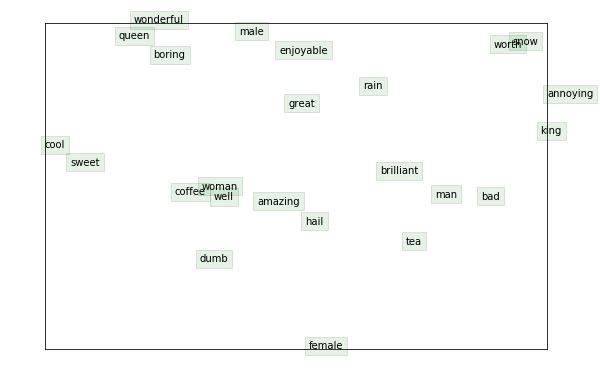

In [45]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
for i in range(len(visualizeWords)):
    ax.text(coord[i,0], coord[i,1], visualizeWords[i],
        bbox=dict(facecolor='green', alpha=0.1))

ax.set_xlim((np.min(coord[:,0]), np.max(coord[:,0])))
ax.set_ylim((np.min(coord[:,1]), np.max(coord[:,1])))
ax.xaxis.label.set_color('w')
ax.yaxis.label.set_color('w')
ax.tick_params(axis='x', colors='w')
ax.tick_params(axis='y', colors='w')
ax.set_title('Word Embedding Space', color='w');